# More experiments with the Universal Sentence Encoder

## Load packages and external data

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
from nltk import download
from nltk.tokenize import sent_tokenize
from sklearn.cluster import MiniBatchKMeans
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_roc_curve
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [3]:
download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Define functions

In [4]:
def process_doc(doc):
  doc_carriage_return = doc.split('\n')
  doc_processed = [line for line in doc_carriage_return if line != '']
  return (doc_processed)


def set_to_embed(X_set):
  X = []
  for doc in X_set:
    doc_processed = process_doc(doc)
    for sentence in doc_processed:
      X.append(sentence)
  return np.array(X)


def cluster_encoder(doc, clust):
  doc_processed = process_doc(doc)
  return clust.predict(embed(doc_processed).numpy())


def cluster_counts(doc, clust):
  count_vector = np.zeros(clust.n_clusters)
  encoded_doc = cluster_encoder(doc, clust)
  for i in encoded_doc:
    count_vector[i] += 1
  return count_vector


def count_matrix(set, clust):
  count_matrix = []
  for doc in set:
    count_matrix.append(cluster_counts(doc, clust))
  return count_matrix

## Load the data

In [5]:
train = pd.read_csv('/content/train.csv')
X_train_raw = train.X
y_train = train.y

test = pd.read_csv('/content/test.csv')
X_test_raw = test.X
y_test = test.y

## Embed with the universal sentence encoder

In [6]:
X_train_embed = embed(set_to_embed(X_train_raw))
X_test_embed = embed(set_to_embed(X_test_raw))

## Find clusters

In [7]:
clust = MiniBatchKMeans(n_clusters=400, batch_size=1000, verbose=0, max_no_improvement=200)
X_clust = clust.fit(X_train_embed)

In [8]:
clust.counts_

array([  902.,  5184.,   816.,   818.,   818., 76435.,  1356.,  2216.,
        1168.,  1992.,   823.,   818.,   816.,   828.,   820.,   816.,
         818.,   819.,   816.,   818.,   816.,   817.,   816.,   832.,
         817.,   816.,  4510.,   816.,   818.,   834.,   817.,   827.,
         816.,  3935.,  1125.,   816.,   816.,   816.,   821.,   816.,
         816.,  3010.,  1218.,   816.,   816.,   816.,   817.,  2421.,
         816.,   816.,   816.,   824.,   816.,   819.,   816.,   816.,
         816.,   861.,   816.,   817.,   816.,   816.,   816.,   816.,
         818.,   816.,   837.,   816.,  1684.,   818.,   816.,   816.,
         816.,  2160.,   816.,   816.,   818.,  3753.,   818.,   817.,
         816.,   816.,   819.,   816.,   816.,   816.,   817.,   816.,
         820.,   816.,   819.,   816.,   817.,   816.,  1146.,   820.,
         816.,   816.,   820.,   816.,   816.,   816.,   816.,   819.,
         817.,   816.,   819.,   818.,   823.,   816.,   823.,   816.,
      

## Generate count matricies

In [9]:
X_train = np.array([cluster_counts(doc, clust) for doc in X_train_raw])
X_test = np.array([cluster_counts(doc, clust) for doc in X_test_raw])

## Classifier tests

### Test 1 - Naive Bayes using counts

In [10]:
NB = MultinomialNB()

In [11]:
NB.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

Training accuracy
0.5703245749613601


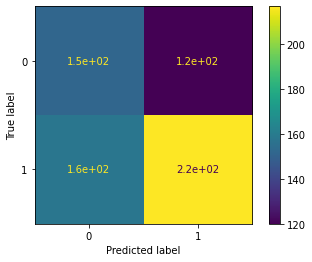

In [12]:
print('Training accuracy')
print(NB.score(X_train, y_train))
plot_confusion_matrix(NB, X_train, y_train)

Test accuracy
0.4691358024691358


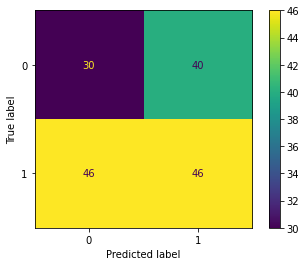

In [13]:
print('Test accuracy')
print(NB.score(X_test, y_test))
plot_confusion_matrix(NB, X_test, y_test)

### Test 2 - Naive Bayes using tf-idf

In [14]:
tfidf = TfidfTransformer()
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [15]:
NB.fit(X_train_tfidf, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

Training accuracy
0.6043276661514683


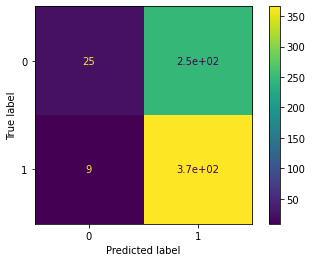

In [16]:
print('Training accuracy')
print(NB.score(X_train_tfidf, y_train))
plot_confusion_matrix(NB, X_train_tfidf, y_train)

Test accuracy
0.5432098765432098


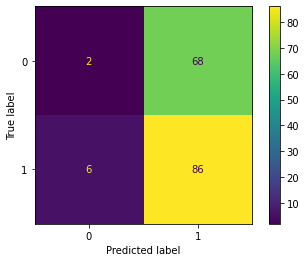

In [17]:
print('Test accuracy')
print(NB.score(X_test_tfidf, y_test))
plot_confusion_matrix(NB, X_test_tfidf, y_test)

### Logistic regression

In [18]:
model_lr = tf.keras.Sequential([
                                tf.keras.layers.Input(X_train_tfidf[0].shape),
                                tf.keras.layers.Dense(1, activation='sigmoid')
])

model_lr.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1, 1)              401       
Total params: 401
Trainable params: 401
Non-trainable params: 0
_________________________________________________________________


In [19]:
model_lr.compile(optimizer='rmsprop',
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

In [20]:
model_lr.fit(x = X_train_tfidf.todense(), y=y_train,
            validation_data=(X_test_tfidf.todense(), y_test),
            epochs=10)

Epoch 1/10


16/21 [=====================>........] - ETA: 0s - loss: 0.6966 - accuracy: 0.4453WARNING:tensorflow:Model was constructed with shape (None, 1, 400) for input Tensor("input_1:0", shape=(None, 1, 400), dtype=float32), but it was called on an input with incompatible shape (None, 400).


21/21 [==============================] - 0s 13ms/step - loss: 0.6961 - accuracy: 0.4513 - val_loss: 0.6937 - val_accuracy: 0.4938
Epoch 2/10
21/21 [==============================] - 0s 5ms/step - loss: 0.6921 - accuracy: 0.5054 - val_loss: 0.6917 - val_accuracy: 0.5000
Epoch 3/10
21/21 [==============================] - 0s 5ms/step - loss: 0.6894 - accuracy: 0.5240 - val_loss: 0.6900 - val_accuracy: 0.5617
Epoch 4/10
21/21 [==============================] - 0s 6ms/step - loss: 0.6870 - accuracy: 0.5688 - val_loss: 0.6888 - val_accuracy: 0.5679
Epoch 5/10
21/21 [==============================] - 0s 6ms/step - loss: 0.6851 - accuracy: 0.5827 - val_loss: 0.6877 - val_accuracy: 0.5617
Epoch 6/10
21/21 [==============================] - 0s 5ms/step - loss: 0.6832 - accuracy: 0.5827 - val_loss: 0.6872 - val_accuracy: 0.5679
Epoch 7/10
21/21 [==============================] - 0s 5ms/step - loss: 0.6820 - accuracy: 0.5811 - val_loss: 0.6867 - val_accuracy: 0.5679
Epoch 8/10
21/21 [============

### Multi-Layer Preceptron backed by tf-idf

In [21]:
model = tf.keras.Sequential([
                             tf.keras.layers.Input(X_train_tfidf.shape[1]),
                             tf.keras.layers.Dense(256, activation='relu'),
                             tf.keras.layers.Dense(256, activation='relu'),
                             tf.keras.layers.Dense(512, activation='relu'),
                             tf.keras.layers.Dense(512, activation='relu'),
                             tf.keras.layers.Dense(1024, activation='relu'),
                             tf.keras.layers.Dense(1024, activation='relu'),
                             tf.keras.layers.Dropout(0.3),
                             tf.keras.layers.Dense(1, activation='sigmoid')
])

In [22]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               102656    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_3 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_4 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              525312    
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout (Dropout)            (None, 1024)             

In [23]:
model.reset_states()
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [24]:
model.fit(x=X_train_tfidf.todense(), y=y_train, validation_data=(X_test_tfidf.todense(), y_test),
          epochs=20)

Epoch 1/20
21/21 [==============================] - 0s 15ms/step - loss: 0.6919 - accuracy: 0.5626 - val_loss: 0.6885 - val_accuracy: 0.5679
Epoch 2/20
21/21 [==============================] - 0s 9ms/step - loss: 0.6846 - accuracy: 0.5796 - val_loss: 0.6854 - val_accuracy: 0.5679
Epoch 3/20
21/21 [==============================] - 0s 9ms/step - loss: 0.6458 - accuracy: 0.6182 - val_loss: 0.7634 - val_accuracy: 0.5556
Epoch 4/20
21/21 [==============================] - 0s 10ms/step - loss: 0.6013 - accuracy: 0.6909 - val_loss: 0.7403 - val_accuracy: 0.4506
Epoch 5/20
21/21 [==============================] - 0s 10ms/step - loss: 0.5415 - accuracy: 0.7094 - val_loss: 1.1051 - val_accuracy: 0.4877
Epoch 6/20
21/21 [==============================] - 0s 9ms/step - loss: 0.4773 - accuracy: 0.7635 - val_loss: 1.2214 - val_accuracy: 0.5556
Epoch 7/20
21/21 [==============================] - 0s 10ms/step - loss: 0.4187 - accuracy: 0.8006 - val_loss: 1.3087 - val_accuracy: 0.5556
Epoch 8/20
21/21